In [1]:
import struct
import dataProcess
import numpy as np
import PIL
import matplotlib.pyplot as plt
import multiprocessing as mp
import seaborn as sns
import pandas as pd
import cv2
cv2.__version__

def release(a):
   del a[:]
   del a

%matplotlib inline

train_data_dir = "HWDB1.1trn_gnt"
test_data_dir = "HWDB1.1tst_gnt"

In [2]:
images = []
labels = []
#X_test = []
#y_test =[]

for image, tagcode in dataProcess.read_from_gnt_dir(train_data_dir):
    tagcode_unicode = struct.pack('>H', tagcode).decode('gb2312')
    images.append(image)
    labels.append(tagcode_unicode)
    
#pool2 = mp.Pool()

"""
for image, tagcode in dataProcess.read_from_gnt_dir(test_data_dir):
    tagcode_unicode = struct.pack('>H', tagcode).decode('gb2312')
    test_counter += 1
    X_test.append(image)
    y_test.append(tagcode_unicode)
 
"""

"\nfor image, tagcode in dataProcess.read_from_gnt_dir(test_data_dir):\n    tagcode_unicode = struct.pack('>H', tagcode).decode('gb2312')\n    test_counter += 1\n    X_test.append(image)\n    y_test.append(tagcode_unicode)\n \n"

In [3]:
images = np.array(images)
labels = np.array(labels)

In [4]:
print(images[0].shape)
print(np.unique(labels).shape)

(76, 66)
(3755,)


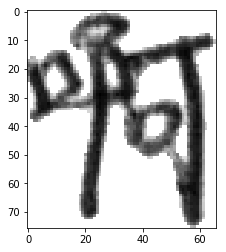

In [5]:
plt.imshow(images[0], cmap='gray')

## 绘制“笔画-$\sqrt{像素}$     ”图形
### 查询每个label的笔画
`bihua.txt`记录了所有unicode汉字的笔画信息

In [6]:
book = open('bihua.txt').readlines()
bihua_dict = {}
for line in book:
    words = line.strip().split()
    bihua_dict[words[0]] = int(words[1])
print(bihua_dict['木'])
labels_bihua = [bihua_dict[y] for y in labels]

4


### 计算$\sqrt{像素点}$

In [7]:
images_pn = [np.sqrt(img.shape[0] * img.shape[1]) for img in images]

将数据放入类DataFrame中

In [8]:
df = pd.DataFrame({'idx':[i for i in range(images.shape[0])],
                  'bihua':labels_bihua,
                  'pixels_num':images_pn}) 
df = df.sort_values(by=['bihua'])

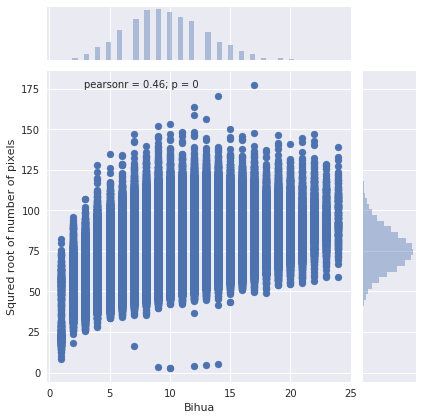

In [9]:
sns.set()

g = sns.jointplot(x="bihua", y="pixels_num", data=df)
g.set_axis_labels("Bihua", "Squred root of number of pixels");
g.savefig("bihua_sp.png")
plt.show()

## 使用One-class SVM with RBF检测outliers
数据太大，跑了一个多小时不出结果，放弃。我大概看了许多，极端数据和错误分类应该没有想象的那么可怕，所以暂时用阈值吧。

In [ ]:
from sklearn import svm
df_od = df[['pixels_num', 'bihua']].values

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(df_od)
y_pred = clf.predict(df_od)
print(len(y_pred))

## 使用阈值过滤尺寸小的图片
调参：

6 15
腰


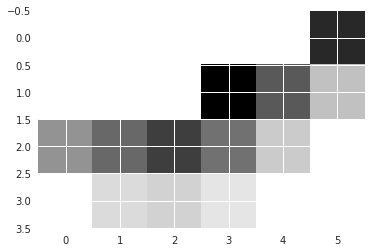

In [10]:
min_h = 999
min_w = 999
img_min = []
i = 0
for idx,img in enumerate(images): 
    i+=1
    if img.shape[0] <= 25 and img.shape[1] <= 25:
        img_min = img
        y_min = labels[i-1]
        continue
    min_h = min_h if img.shape[0]>min_h else img.shape[0]
    min_w = min_w if img.shape[1]>min_w else img.shape[1]
print(min_h, min_w)
print(y_min)
plt.imshow(img_min, cmap='gray')

In [11]:
images_filtered = []
labels_filtered = []
for i,img in enumerate(images): 
    if img.shape[0] > 25 or img.shape[1] > 25:
        images_filtered.append(img)
        labels_filtered.append(labels[i])
images_filtered = np.array(images_filtered)
labels_filtered = np.array(labels_filtered)
print(images_filtered.shape, labels_filtered.shape)

(897747,) (897747,)


In [12]:
images = []

训练只取其width或者height大于25的,这种方法能过滤11个样本

## Padding with 255
scipy的imresize移到了skimage，skimage不能处理灰度图像，还要转换一次。。。只能用OpenCV了。

In [13]:
from skimage import data, color
from skimage.transform import resize

def impad(img, full_shape=(128,128)):
    (fh, fw) = full_shape
    (h, w) = img.shape
    if h >= fh:
        img = cv2.resize(img, (int(w*(fh/h)), fh))
        (h, w) = img.shape
    if w >= fw:
        img = cv2.resize(img, (int(h*(fw/w)), fw))
        (h, w) = img.shape
    
    x = 0 if fh-h<=0 else np.random.randint(0,fh-h)
    y = 0 if fw-w<=0 else np.random.randint(0,fw-w)
    
    result = np.full(full_shape,255)
    result[x:img.shape[0]+x,y:img.shape[1]+y] = img
    return result.reshape(fh,fw,1)


润


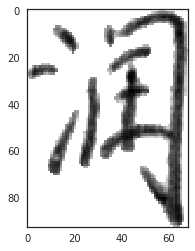

In [14]:
sns.set_style("white")
print(labels[2333])
plt.imshow(images_filtered[2333], cmap='gray')

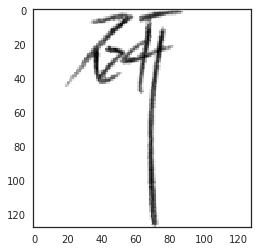

In [15]:
padded_img = impad(img, full_shape=(128,128))
plt.imshow(padded_img.reshape((128,128)), cmap='gray')

## Checkpoint
let's rock'n roll!

In [20]:
import keras

In [21]:
from keras import utils#.to_categorical
from keras.preprocessing.image import ImageDataGenerator

In [32]:
all_labels = np.unique(labels)
labels_to_idx_dict = {all_labels[i]:i for i in range(all_labels.shape[0])}
idx_to_labels_dict = {i:all_labels[i] for i in range(all_labels.shape[0])}
print(all_labels.shape, len(labels_to_idx_dict))
labels_filtered_index = [labels_to_idx_dict[i] for i in labels_filtered]
print(labels_filtered_index[0:10])

(3755,) 3755
[593, 3532, 698, 1353, 565, 582, 557, 2275, 2264, 2927]


由于Keras的ImageDataGenerator强制要求"Input to `.fit()` should have rank 4."，所以又要自己造轮子。。
这个地方来来回回试了很多次，把full_shape换成了(64,64)才勉强可以，然而把八十多万组数据一下子全部跑完，我的32G内存直接炸。嗯，一定是因为我没有128内存23333

In [ ]:
X_train = np.array([impad(x,full_shape=(64,64)) for x in images_filtered[:233333]])

In [23]:
y_train = np.array(utils.to_categorical(labels_filtered_index[:233333], all_labels.shape[0]))

#datagen = ImageDataGenerator(preprocessing_function=impad)
#datagen.fit(X_train)
#X_train = [impad(x) for x in X_train]

In [21]:
#del images_filtered

In [23]:
import gc
gc.enable()
gc.collect()

5963

用垃圾模型测试。这个垃圾模型能让我的1080使用率跑到65-90%

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 256
num_classes = all_labels.shape[0]
epochs = 10
full_shape = (64,64,1) # Tensorflow dataformat: channel_last

In [37]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=full_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [ ]:
model.fit(X_train,
       y_train,
       batch_size=batch_size,
       validation_split=0.2,
       epochs=epochs,
       shuffle=True)

In [ ]:
print(idx_to_labels_dict[np.argmax(y_train[30])])
plt.imshow(X_train[30].reshape((64,64)), cmap='gray')